<font size="+3">Time-series Generative Adversarial Network (TimeGAN)</font>

# Imports & Settings

Adapted from the excellent paper by Jinsung Yoon, Daniel Jarrett, and Mihaela van der Schaar:  
[Time-series Generative Adversarial Networks](https://papers.nips.cc/paper/8789-time-series-generative-adversarial-networks),  
Neural Information Processing Systems (NeurIPS), 2019.

- [Original code](https://bitbucket.org/mvdschaar/mlforhealthlabpub/src/master/alg/timegan/) author: Jinsung Yoon (jsyoon0823@gmail.com)

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from pathlib import Path
from tqdm import tqdm

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import GRU, Dense, RNN, GRUCell, Input
from tensorflow.keras.losses import BinaryCrossentropy, MeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.utils import plot_model

import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if gpu_devices:
    print('Using GPU')
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
else:
    print('Using CPU')

Using CPU


In [5]:
sns.set_style('white')

# Experiment Path

In [6]:
results_path = Path('time_gan')
if not results_path.exists():
    results_path.mkdir()

In [7]:
experiment = 0

In [8]:
log_dir = results_path / f'experiment_{experiment:02}'
if not log_dir.exists():
    log_dir.mkdir(parents=True)

In [9]:
hdf_store = results_path / 'TimeSeriesGAN.h5'

# Prepare Data

## Parameters

In [17]:
import yfinance as yf

In [18]:
seq_len = 24
n_seq = 6
batch_size = 128

In [1]:
import yfinance as yf
import pandas as pd

# Define ticker symbols and date range
tickers = ['BA', 'CAT', 'DIS', 'GE', 'IBM', 'KO']
start_date = '2000-01-01'
end_date = '2020-12-31'

# Download data from Yahoo Finance
raw_data = yf.download(tickers, start=start_date, end=end_date)

# Get only the 'Close' prices
adj_close_data = raw_data['Close']

# Save full data to HDF5
adj_close_data.to_hdf('assets.h5', key='quandl/wiki/prices')

# ✅ Save a portion (e.g., first 500 rows) to CSV
adj_close_data.head(500).to_csv('adj_close_subset.csv')

# Or, save the entire data to CSV if you prefer:
# adj_close_data.to_csv('adj_close_full.csv')


C:\Users\balam\AppData\Local\Temp\ipykernel_21972\787790350.py:10: FutureWarning: YF.download() has changed argument auto_adjust default to True
  raw_data = yf.download(tickers, start=start_date, end=end_date)
[*********************100%***********************]  6 of 6 completed


In [28]:
def select_data():
    df = pd.read_hdf('assets.h5', 'quandl/wiki/prices')  # Load 'Close' prices
    df = df.loc['2000':, tickers]  # Keep only specified tickers and date range
    df = df.dropna()  # Remove any rows with missing values
    df.to_hdf(hdf_store, 'data/real')  # Save cleaned data for TimeGAN


In [29]:
select_data()

## Plot Series

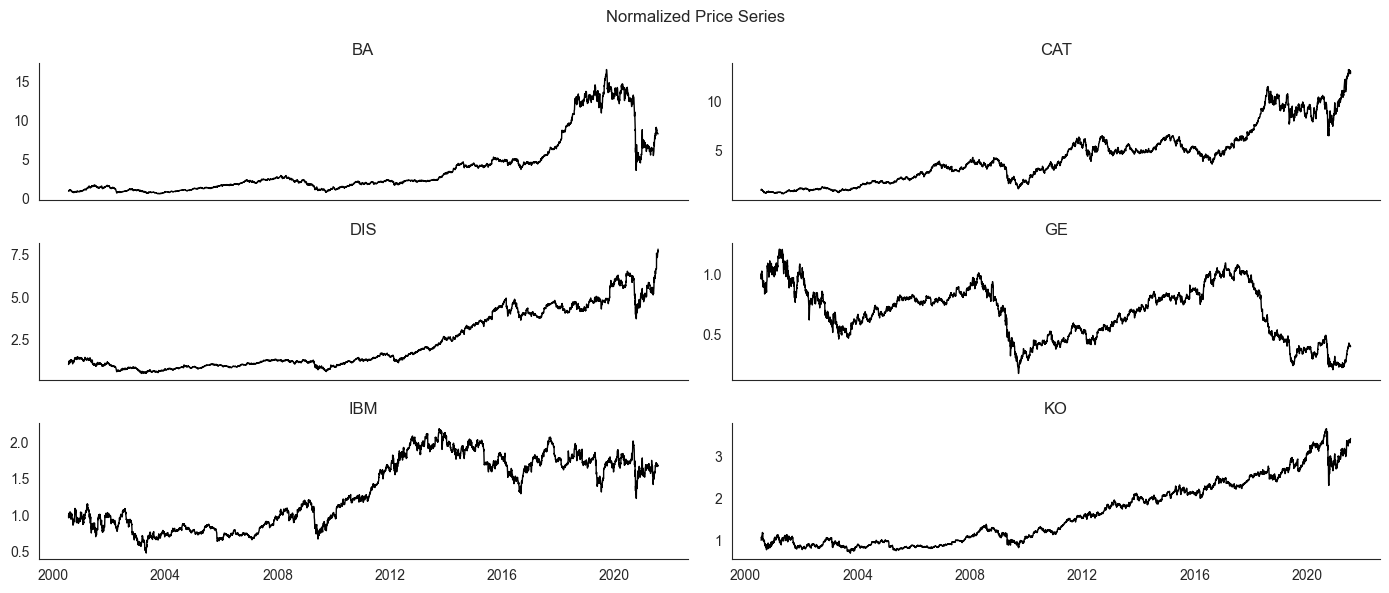

In [30]:
df = pd.read_hdf(hdf_store, 'data/real')
axes = df.div(df.iloc[0]).plot(subplots=True,
                               figsize=(14, 6),
                               layout=(3, 2),
                               title=tickers,
                               legend=False,
                               rot=0,
                               lw=1, 
                               color='k')
for ax in axes.flatten():
    ax.set_xlabel('')

plt.suptitle('Normalized Price Series')
plt.gcf().tight_layout()
sns.despine();

## Correlation

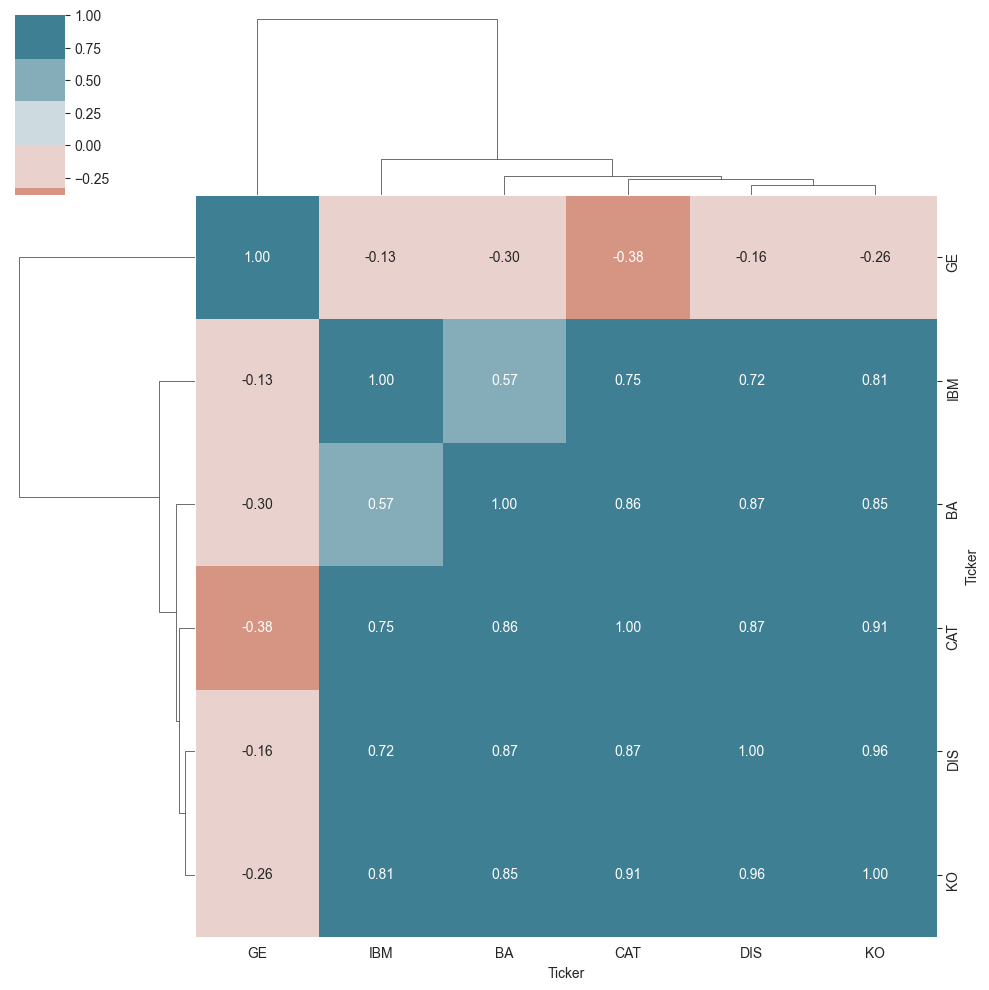

In [31]:
sns.clustermap(df.corr(),
               annot=True,
               fmt='.2f',
               cmap=sns.diverging_palette(h_neg=20,
                                          h_pos=220), center=0);

## Normalize Data

In [32]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df).astype(np.float32)

## Create rolling window sequences

In [33]:
data = []
for i in range(len(df) - seq_len):
    data.append(scaled_data[i:i + seq_len])

n_windows = len(data)

## Create tf.data.Dataset

In [34]:
real_series = (tf.data.Dataset
               .from_tensor_slices(data)
               .shuffle(buffer_size=n_windows)
               .batch(batch_size))
real_series_iter = iter(real_series.repeat())

## Set up random series generator

In [35]:
def make_random_data():
    while True:
        yield np.random.uniform(low=0, high=1, size=(seq_len, n_seq))

We use the Python generator to feed a `tf.data.Dataset` that continues to call the random number generator as long as necessary and produces the desired batch size.

In [36]:
random_series = iter(tf.data.Dataset
                     .from_generator(make_random_data, output_types=tf.float32)
                     .batch(batch_size)
                     .repeat())

# TimeGAN Components

The design of the TimeGAN components follows the author's sample code.

##  Network Parameters

In [37]:
hidden_dim = 24
num_layers = 3

## Set up logger

In [38]:
writer = tf.summary.create_file_writer(log_dir.as_posix())

## Input place holders

In [39]:
X = Input(shape=[seq_len, n_seq], name='RealData')
Z = Input(shape=[seq_len, n_seq], name='RandomData')

## RNN block generator

We keep it very simple and use a very similar architecture for all four components. For a real-world application, they should be tailored to the data.

In [40]:
def make_rnn(n_layers, hidden_units, output_units, name):
    return Sequential([GRU(units=hidden_units,
                           return_sequences=True,
                           name=f'GRU_{i + 1}') for i in range(n_layers)] +
                      [Dense(units=output_units,
                             activation='sigmoid',
                             name='OUT')], name=name)

## Embedder & Recovery

In [41]:
embedder = make_rnn(n_layers=3, 
                    hidden_units=hidden_dim, 
                    output_units=hidden_dim, 
                    name='Embedder')
recovery = make_rnn(n_layers=3, 
                    hidden_units=hidden_dim, 
                    output_units=n_seq, 
                    name='Recovery')

## Generator & Discriminator

In [42]:
generator = make_rnn(n_layers=3, 
                     hidden_units=hidden_dim, 
                     output_units=hidden_dim, 
                     name='Generator')
discriminator = make_rnn(n_layers=3, 
                         hidden_units=hidden_dim, 
                         output_units=1, 
                         name='Discriminator')
supervisor = make_rnn(n_layers=2, 
                      hidden_units=hidden_dim, 
                      output_units=hidden_dim, 
                      name='Supervisor')

# TimeGAN Training

## Settings

In [43]:
train_steps = 10000
gamma = 1

## Generic Loss Functions

In [44]:
mse = MeanSquaredError()
bce = BinaryCrossentropy()

# Phase 1: Autoencoder Training

## Architecture

In [45]:
H = embedder(X)
X_tilde = recovery(H)

autoencoder = Model(inputs=X,
                    outputs=X_tilde,
                    name='Autoencoder')

In [46]:
autoencoder.summary()

Model: "Autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 RealData (InputLayer)       [(None, 24, 6)]           0         
                                                                 
 Embedder (Sequential)       (None, 24, 24)            10104     
                                                                 
 Recovery (Sequential)       (None, 24, 6)             10950     
                                                                 
Total params: 21054 (82.24 KB)
Trainable params: 21054 (82.24 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [51]:
# plot_model(autoencoder,
#            to_file=(results_path / 'autoencoder.png').as_posix(),
#            show_shapes=True)

## Autoencoder Optimizer

In [48]:
autoencoder_optimizer = Adam()

## Autoencoder Training Step

In [49]:
@tf.function
def train_autoencoder_init(x):
    with tf.GradientTape() as tape:
        x_tilde = autoencoder(x)
        embedding_loss_t0 = mse(x, x_tilde)
        e_loss_0 = 10 * tf.sqrt(embedding_loss_t0)

    var_list = embedder.trainable_variables + recovery.trainable_variables
    gradients = tape.gradient(e_loss_0, var_list)
    autoencoder_optimizer.apply_gradients(zip(gradients, var_list))
    return tf.sqrt(embedding_loss_t0)

## Autoencoder Training Loop

In [52]:
for step in tqdm(range(train_steps)):
    X_ = next(real_series_iter)
    step_e_loss_t0 = train_autoencoder_init(X_)
    with writer.as_default():
        tf.summary.scalar('Loss Autoencoder Init', step_e_loss_t0, step=step)

100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [06:58<00:00, 23.91it/s]


## Persist model

In [53]:
# autoencoder.save(log_dir / 'autoencoder')

# Phase 2: Supervised training

## Define Optimizer

In [54]:
supervisor_optimizer = Adam()

## Train Step

In [55]:
@tf.function
def train_supervisor(x):
    with tf.GradientTape() as tape:
        h = embedder(x)
        h_hat_supervised = supervisor(h)
        g_loss_s = mse(h[:, 1:, :], h_hat_supervised[:, :-1, :])

    var_list = supervisor.trainable_variables
    gradients = tape.gradient(g_loss_s, var_list)
    supervisor_optimizer.apply_gradients(zip(gradients, var_list))
    return g_loss_s

## Training Loop

In [56]:
for step in tqdm(range(train_steps)):
    X_ = next(real_series_iter)
    step_g_loss_s = train_supervisor(X_)
    with writer.as_default():
        tf.summary.scalar('Loss Generator Supervised Init', step_g_loss_s, step=step)

100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [04:18<00:00, 38.61it/s]


## Persist Model

In [57]:
# supervisor.save(log_dir / 'supervisor')

# Joint Training

## Generator

### Adversarial Architecture - Supervised

In [58]:
E_hat = generator(Z)
H_hat = supervisor(E_hat)
Y_fake = discriminator(H_hat)

adversarial_supervised = Model(inputs=Z,
                               outputs=Y_fake,
                               name='AdversarialNetSupervised')

In [59]:
adversarial_supervised.summary()

Model: "AdversarialNetSupervised"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 RandomData (InputLayer)     [(None, 24, 6)]           0         
                                                                 
 Generator (Sequential)      (None, 24, 24)            10104     
                                                                 
 Supervisor (Sequential)     (None, 24, 24)            7800      
                                                                 
 Discriminator (Sequential)  (None, 24, 1)             10825     
                                                                 
Total params: 28729 (112.22 KB)
Trainable params: 28729 (112.22 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


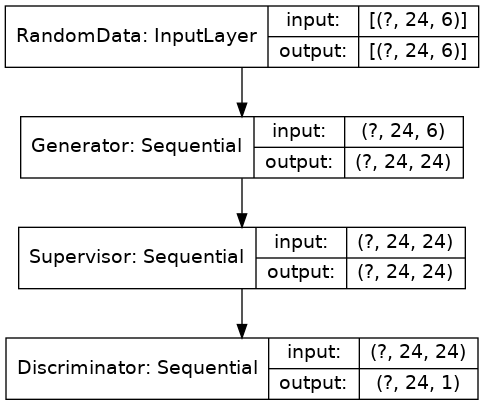

In [41]:
plot_model(adversarial_supervised, show_shapes=True)

### Adversarial Architecture in Latent Space

In [60]:
Y_fake_e = discriminator(E_hat)

adversarial_emb = Model(inputs=Z,
                    outputs=Y_fake_e,
                    name='AdversarialNet')

In [61]:
adversarial_emb.summary()

Model: "AdversarialNet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 RandomData (InputLayer)     [(None, 24, 6)]           0         
                                                                 
 Generator (Sequential)      (None, 24, 24)            10104     
                                                                 
 Discriminator (Sequential)  (None, 24, 1)             10825     
                                                                 
Total params: 20929 (81.75 KB)
Trainable params: 20929 (81.75 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


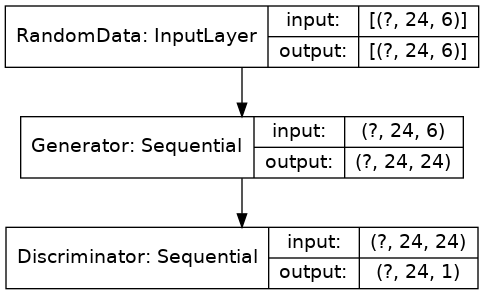

In [44]:
plot_model(adversarial_emb, show_shapes=True)

### Mean & Variance Loss

In [62]:
X_hat = recovery(H_hat)
synthetic_data = Model(inputs=Z,
                       outputs=X_hat,
                       name='SyntheticData')

In [63]:
synthetic_data.summary()

Model: "SyntheticData"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 RandomData (InputLayer)     [(None, 24, 6)]           0         
                                                                 
 Generator (Sequential)      (None, 24, 24)            10104     
                                                                 
 Supervisor (Sequential)     (None, 24, 24)            7800      
                                                                 
 Recovery (Sequential)       (None, 24, 6)             10950     
                                                                 
Total params: 28854 (112.71 KB)
Trainable params: 28854 (112.71 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


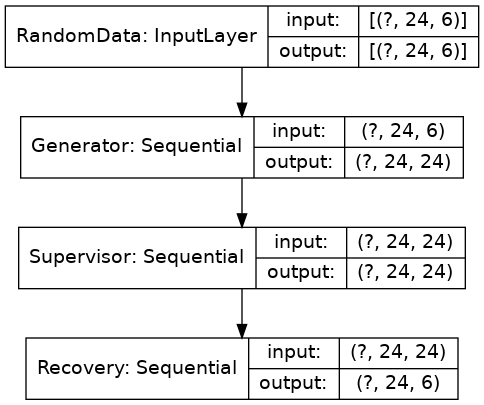

In [47]:
plot_model(synthetic_data, show_shapes=True)

In [64]:
def get_generator_moment_loss(y_true, y_pred):
    y_true_mean, y_true_var = tf.nn.moments(x=y_true, axes=[0])
    y_pred_mean, y_pred_var = tf.nn.moments(x=y_pred, axes=[0])
    g_loss_mean = tf.reduce_mean(tf.abs(y_true_mean - y_pred_mean))
    g_loss_var = tf.reduce_mean(tf.abs(tf.sqrt(y_true_var + 1e-6) - tf.sqrt(y_pred_var + 1e-6)))
    return g_loss_mean + g_loss_var

## Discriminator

### Architecture: Real Data

In [65]:
Y_real = discriminator(H)
discriminator_model = Model(inputs=X,
                            outputs=Y_real,
                            name='DiscriminatorReal')

In [66]:
discriminator_model.summary()

Model: "DiscriminatorReal"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 RealData (InputLayer)       [(None, 24, 6)]           0         
                                                                 
 Embedder (Sequential)       (None, 24, 24)            10104     
                                                                 
 Discriminator (Sequential)  (None, 24, 1)             10825     
                                                                 
Total params: 20929 (81.75 KB)
Trainable params: 20929 (81.75 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


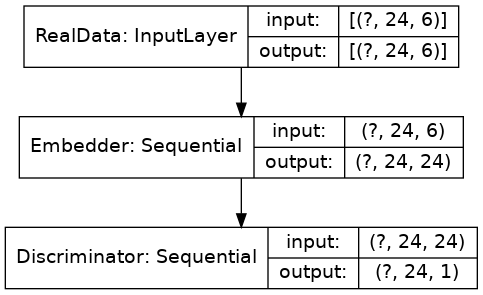

In [51]:
plot_model(discriminator_model, show_shapes=True)

## Optimizers

In [67]:
generator_optimizer = Adam()
discriminator_optimizer = Adam()
embedding_optimizer = Adam()

## Generator Train Step

In [68]:
@tf.function
def train_generator(x, z):
    with tf.GradientTape() as tape:
        y_fake = adversarial_supervised(z)
        generator_loss_unsupervised = bce(y_true=tf.ones_like(y_fake),
                                          y_pred=y_fake)

        y_fake_e = adversarial_emb(z)
        generator_loss_unsupervised_e = bce(y_true=tf.ones_like(y_fake_e),
                                            y_pred=y_fake_e)
        h = embedder(x)
        h_hat_supervised = supervisor(h)
        generator_loss_supervised = mse(h[:, 1:, :], h_hat_supervised[:, 1:, :])

        x_hat = synthetic_data(z)
        generator_moment_loss = get_generator_moment_loss(x, x_hat)

        generator_loss = (generator_loss_unsupervised +
                          generator_loss_unsupervised_e +
                          100 * tf.sqrt(generator_loss_supervised) +
                          100 * generator_moment_loss)

    var_list = generator.trainable_variables + supervisor.trainable_variables
    gradients = tape.gradient(generator_loss, var_list)
    generator_optimizer.apply_gradients(zip(gradients, var_list))
    return generator_loss_unsupervised, generator_loss_supervised, generator_moment_loss

## Embedding Train Step

In [69]:
@tf.function
def train_embedder(x):
    with tf.GradientTape() as tape:
        h = embedder(x)
        h_hat_supervised = supervisor(h)
        generator_loss_supervised = mse(h[:, 1:, :], h_hat_supervised[:, 1:, :])

        x_tilde = autoencoder(x)
        embedding_loss_t0 = mse(x, x_tilde)
        e_loss = 10 * tf.sqrt(embedding_loss_t0) + 0.1 * generator_loss_supervised

    var_list = embedder.trainable_variables + recovery.trainable_variables
    gradients = tape.gradient(e_loss, var_list)
    embedding_optimizer.apply_gradients(zip(gradients, var_list))
    return tf.sqrt(embedding_loss_t0)

## Discriminator Train Step

In [70]:
@tf.function
def get_discriminator_loss(x, z):
    y_real = discriminator_model(x)
    discriminator_loss_real = bce(y_true=tf.ones_like(y_real),
                                  y_pred=y_real)

    y_fake = adversarial_supervised(z)
    discriminator_loss_fake = bce(y_true=tf.zeros_like(y_fake),
                                  y_pred=y_fake)

    y_fake_e = adversarial_emb(z)
    discriminator_loss_fake_e = bce(y_true=tf.zeros_like(y_fake_e),
                                    y_pred=y_fake_e)
    return (discriminator_loss_real +
            discriminator_loss_fake +
            gamma * discriminator_loss_fake_e)

In [71]:
@tf.function
def train_discriminator(x, z):
    with tf.GradientTape() as tape:
        discriminator_loss = get_discriminator_loss(x, z)

    var_list = discriminator.trainable_variables
    gradients = tape.gradient(discriminator_loss, var_list)
    discriminator_optimizer.apply_gradients(zip(gradients, var_list))
    return discriminator_loss

## Training Loop

In [72]:
step_g_loss_u = step_g_loss_s = step_g_loss_v = step_e_loss_t0 = step_d_loss = 0
for step in range(train_steps):
    # Train generator (twice as often as discriminator)
    for kk in range(2):
        X_ = next(real_series_iter)
        Z_ = next(random_series)

        # Train generator
        step_g_loss_u, step_g_loss_s, step_g_loss_v = train_generator(X_, Z_)
        # Train embedder
        step_e_loss_t0 = train_embedder(X_)

    X_ = next(real_series_iter)
    Z_ = next(random_series)
    step_d_loss = get_discriminator_loss(X_, Z_)
    if step_d_loss > 0.15:
        step_d_loss = train_discriminator(X_, Z_)

    if step % 1000 == 0:
        print(f'{step:6,.0f} | d_loss: {step_d_loss:6.4f} | g_loss_u: {step_g_loss_u:6.4f} | '
              f'g_loss_s: {step_g_loss_s:6.4f} | g_loss_v: {step_g_loss_v:6.4f} | e_loss_t0: {step_e_loss_t0:6.4f}')

    with writer.as_default():
        tf.summary.scalar('G Loss S', step_g_loss_s, step=step)
        tf.summary.scalar('G Loss U', step_g_loss_u, step=step)
        tf.summary.scalar('G Loss V', step_g_loss_v, step=step)
        tf.summary.scalar('E Loss T0', step_e_loss_t0, step=step)
        tf.summary.scalar('D Loss', step_d_loss, step=step)

     0 | d_loss: 2.0876 | g_loss_u: 0.6965 | g_loss_s: 0.0002 | g_loss_v: 0.4477 | e_loss_t0: 0.0339
 1,000 | d_loss: 1.0544 | g_loss_u: 2.4087 | g_loss_s: 0.0002 | g_loss_v: 0.0535 | e_loss_t0: 0.0082
 2,000 | d_loss: 1.3999 | g_loss_u: 1.9215 | g_loss_s: 0.0002 | g_loss_v: 0.0437 | e_loss_t0: 0.0081
 3,000 | d_loss: 1.0368 | g_loss_u: 1.2815 | g_loss_s: 0.0002 | g_loss_v: 0.0243 | e_loss_t0: 0.0070
 4,000 | d_loss: 1.1874 | g_loss_u: 1.1788 | g_loss_s: 0.0002 | g_loss_v: 0.0219 | e_loss_t0: 0.0066
 5,000 | d_loss: 1.6404 | g_loss_u: 1.3741 | g_loss_s: 0.0002 | g_loss_v: 0.0178 | e_loss_t0: 0.0067
 6,000 | d_loss: 1.3996 | g_loss_u: 1.5658 | g_loss_s: 0.0002 | g_loss_v: 0.0289 | e_loss_t0: 0.0062
 7,000 | d_loss: 1.4241 | g_loss_u: 1.5350 | g_loss_s: 0.0002 | g_loss_v: 0.0594 | e_loss_t0: 0.0056
 8,000 | d_loss: 1.3255 | g_loss_u: 1.8178 | g_loss_s: 0.0002 | g_loss_v: 0.0582 | e_loss_t0: 0.0051
 9,000 | d_loss: 1.1977 | g_loss_u: 1.5379 | g_loss_s: 0.0002 | g_loss_v: 0.0361 | e_loss_t

## Persist Synthetic Data Generator

In [73]:
synthetic_data.save(log_dir / 'synthetic_data')

INFO:tensorflow:Assets written to: time_gan\experiment_00\synthetic_data\assets


INFO:tensorflow:Assets written to: time_gan\experiment_00\synthetic_data\assets


# Generate Synthetic Data

In [74]:
generated_data = []
for i in range(int(n_windows / batch_size)):
    Z_ = next(random_series)
    d = synthetic_data(Z_)
    generated_data.append(d)

In [75]:
len(generated_data)

41

In [76]:
generated_data = np.array(np.vstack(generated_data))
generated_data.shape

(5248, 24, 6)

In [77]:
np.save(log_dir / 'generated_data.npy', generated_data)

## Rescale

In [78]:
generated_data = (scaler.inverse_transform(generated_data
                                           .reshape(-1, n_seq))
                  .reshape(-1, seq_len, n_seq))
generated_data.shape

(5248, 24, 6)

## Persist Data

In [79]:
with pd.HDFStore(hdf_store) as store:
    store.put('data/synthetic', pd.DataFrame(generated_data.reshape(-1, n_seq),
                                             columns=tickers))

In [80]:
# Save synthetic data to CSV
df_synthetic = pd.DataFrame(generated_data.reshape(-1, n_seq), columns=tickers)
df_synthetic.to_csv(results_path / 'synthetic_timeseries.csv', index=False)


## Plot sample Series

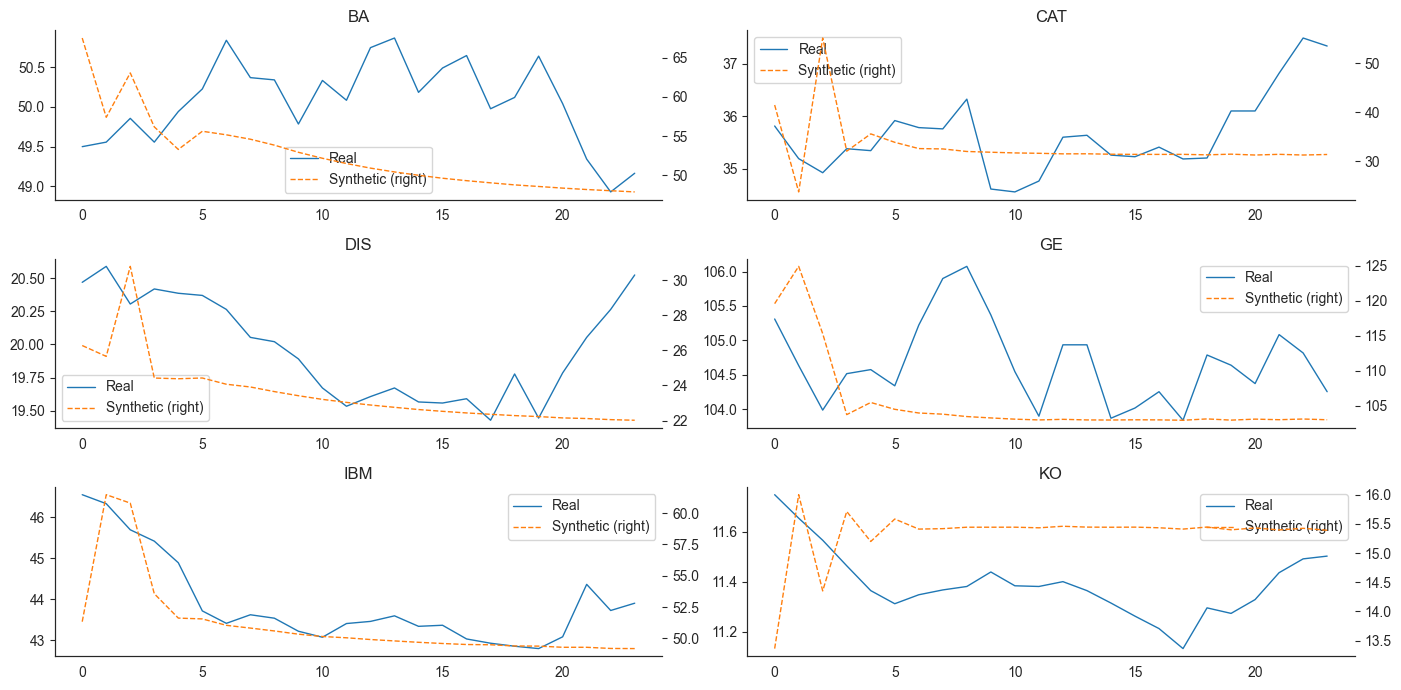

In [81]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(14, 7))
axes = axes.flatten()

index = list(range(1, 25))
synthetic = generated_data[np.random.randint(n_windows)]

idx = np.random.randint(len(df) - seq_len)
real = df.iloc[idx: idx + seq_len]

for j, ticker in enumerate(tickers):
    (pd.DataFrame({'Real': real.iloc[:, j].values,
                   'Synthetic': synthetic[:, j]})
     .plot(ax=axes[j],
           title=ticker,
           secondary_y='Synthetic', style=['-', '--'],
           lw=1))
sns.despine()
fig.tight_layout()